In [2]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
print(df.head(5))

          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive


In [4]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [5]:
X = df.drop(columns="Sepssis")
Y = df[["Sepssis"]]

In [6]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [7]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    df[col] = np.clip(X[col], percentiles[0], percentiles[1])

In [8]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [8]:
# spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6)
print("Training X:", X_train.shape)
print("Testing X: ",X_test.shape)
print("Train Y: ",y_train.shape)

Training X: (449, 8)
Testing X:  (150, 8)
Train Y:  (449, 1)


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
dtf = DecisionTreeClassifier(criterion="gini",max_features=2/3, max_depth=3, random_state=3, class_weight={"Negative":1, "Positive": 2})
# fit model

dtf.fit(X_train, y_train)
# make predictions

yhat = dtf.predict(X_test)

# calculate accuracy

accuracy = metrics.accuracy_score(yhat, y_test)

print('Accuracy: %.3f' % dtf.score(X_test, y_test))

Accuracy: 0.767


In [12]:
text_ = tree.export_text(dtf,feature_names=['BGlucose', 'B1', 'BPressure', 'B2', 'B3', 'BMI', 'B4', 'Age'])
print(text_)

|--- BMI <= 30.25
|   |--- B1 <= 103.50
|   |   |--- BGlucose <= 11.50
|   |   |   |--- class: Negative
|   |   |--- BGlucose >  11.50
|   |   |   |--- class: Positive
|   |--- B1 >  103.50
|   |   |--- Age <= 26.50
|   |   |   |--- class: Negative
|   |   |--- Age >  26.50
|   |   |   |--- class: Negative
|--- BMI >  30.25
|   |--- B1 <= 127.50
|   |   |--- B3 <= 142.50
|   |   |   |--- class: Negative
|   |   |--- B3 >  142.50
|   |   |   |--- class: Positive
|   |--- B1 >  127.50
|   |   |--- B1 <= 154.50
|   |   |   |--- class: Positive
|   |   |--- B1 >  154.50
|   |   |   |--- class: Positive



In [13]:
f_probs = dtf.predict_proba(X_test)
f_probs = f_probs[:,1]
print(metrics.roc_auc_score(y_test, f_probs))

0.8367993662111309


In [14]:
print(metrics.classification_report(y_test, yhat))

              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82        99
    Positive       0.66      0.65      0.65        51

    accuracy                           0.77       150
   macro avg       0.74      0.74      0.74       150
weighted avg       0.77      0.77      0.77       150



/Users/lap11353-local/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


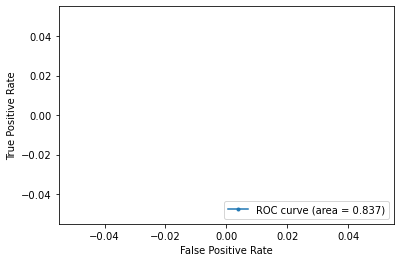

In [20]:
# plot auc, roc
from sklearn.metrics import roc_auc_score, roc_curve
model_probs = dtf.predict_proba(X_test)
# y_score = model_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, f_probs,pos_label=1)
auc = roc_auc_score(y_test, f_probs)

plt.plot(fpr, tpr, marker='.', label= 'ROC curve (area = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')